<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [3]:
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [4]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)


In [5]:
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [6]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords


{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [7]:

with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()


Output()

Output()

array([<Axes: >], dtype=object)

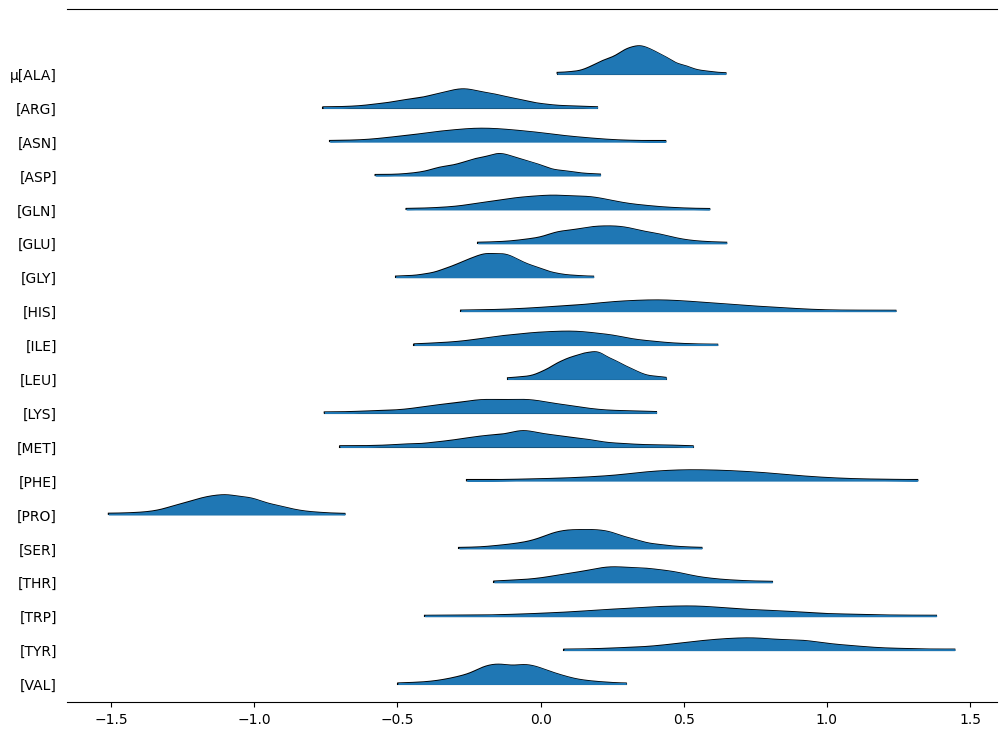

In [8]:
az.plot_forest(idata_cs_h, kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

In [9]:


with pm.Model(coords=aa_coords) as cs_h_studentt_model:
    # hyperpriors. Notice how there's no dims argument.
    #this mea0ns that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu=3, mu = 0, sigma = 10)
    μ_sd = pm.StudentT('μ_sd', nu=3, sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ', nu=3, mu = μ_mu, sigma = μ_sd, dims = "aa")

    σ = pm.HalfStudentT('σ', nu=3, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx], nu=3,
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h_studentt = pm.sample()


Output()

Output()

array([<Axes: >], dtype=object)

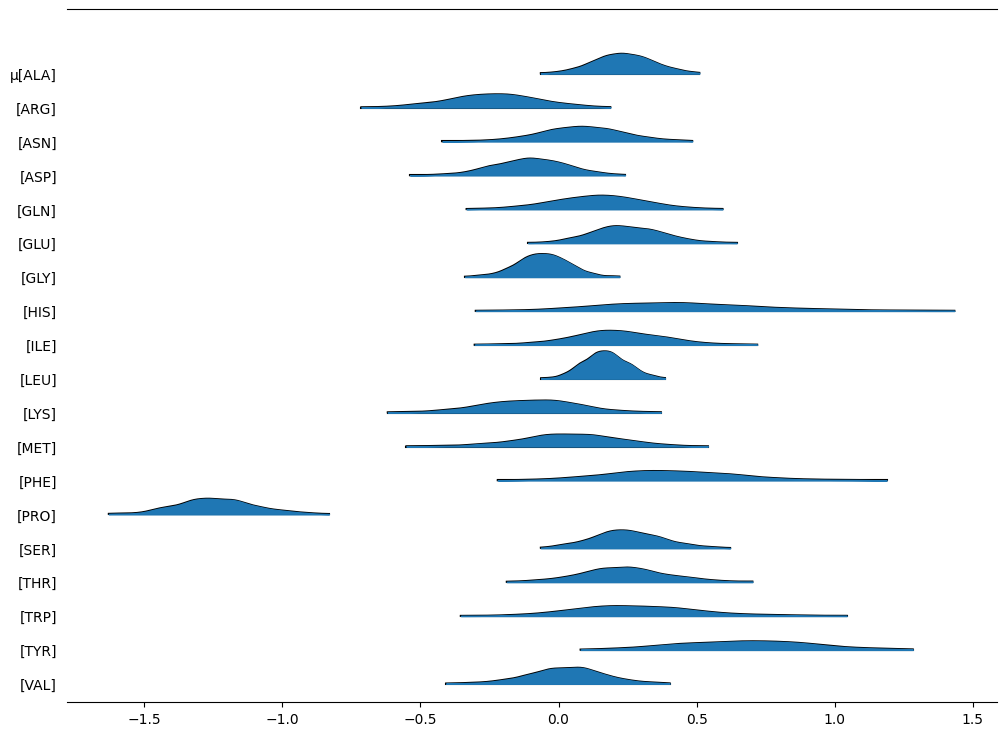

In [10]:
az.plot_forest(idata_cs_h_studentt, kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

StudentT is skewed right so that means it shows more of the extreme values unlike Normal.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [11]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

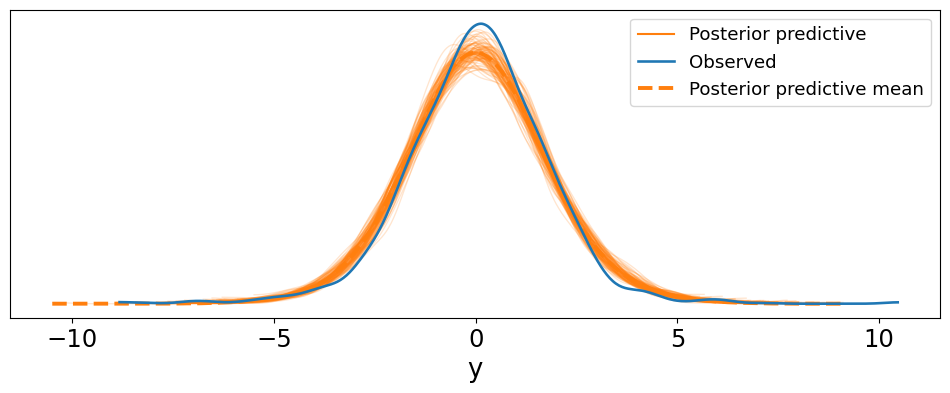

In [12]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Student T

In [25]:
pm.sample_posterior_predictive(idata_cs_h_studentt, model = cs_h_studentt_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

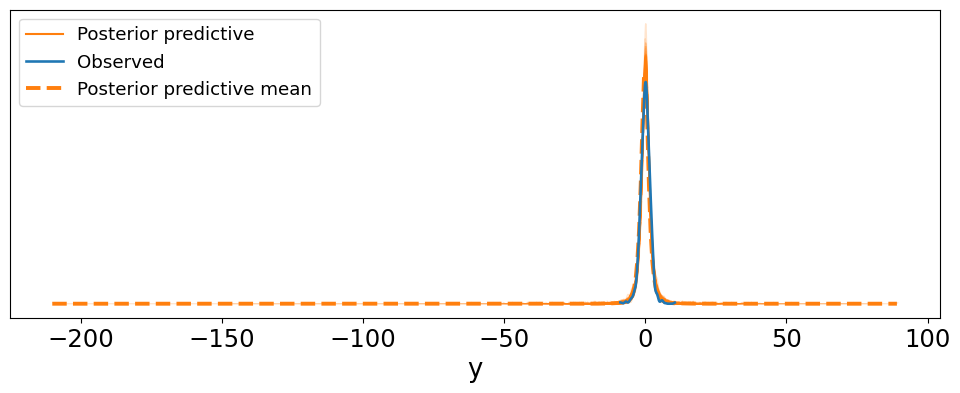

In [26]:
az.plot_ppc(idata_cs_h_studentt, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I think they have almost the same alignment even though the range make them look very different. But StudentT might be better because it loooks really similar to the PPC graph compared to the normal.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [13]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [14]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [15]:

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}


In [16]:
with pm.Model(coords = sccr_coords) as sccr_nh_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

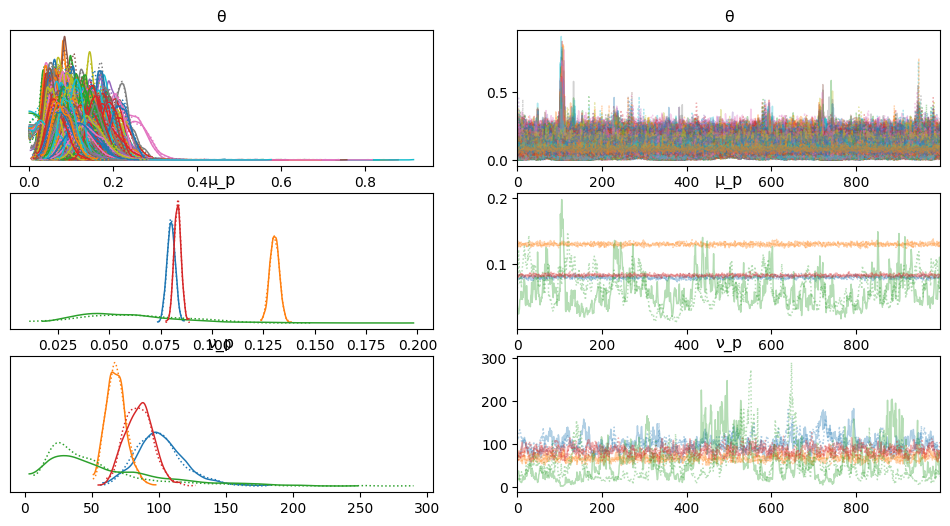

In [17]:
az.plot_trace(idata_sccr_nh)

The hierarchical model is a lot smoother because it averages goals per shot. It also leads to more stable estimates because you can see individual player-level traces. In the Non-Hierarchical Model, the plot_trace for each position's average goals per shot has more sharp points because each group is estimated independently. If it has limited data for certain positions, this can make estimation less stable.

In [18]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.004 1.002 1.002 1.0 ... 1.006 1.004 1.0
    μ_p      (pos) float64 32B 1.008 1.002 1.006 1.0
    ν_p      (pos) float64 32B 1.032 1.003 1.014 0.9998

 For rhat, looking at my μ_p it is closer to 1 compared to that of the notes (meaning it has better convergence than the model in the notes). But the notes' numbers for v_p were closer to one: rhat for that set of data mine had less convergence. The theta is also close to the one in the notes based off of its distance from 0.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

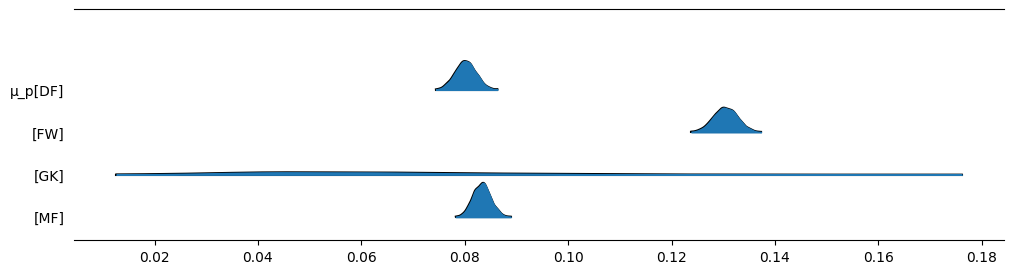

In [21]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The range is smaller compared to the model in the notes.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [23]:
# Remove goalkeepers from the data
sccr_data_no_gk = sccr_data[sccr_data.position != 'GK']

# Update position indices and categories
pos_idx_no_gk = sccr_data_no_gk.position.cat.codes.values
pos_codes_no_gk = sccr_data_no_gk.position.cat.categories

# Update coordinates
sccr_coords_no_gk = {"pos": pos_codes_no_gk}

with pm.Model(coords=sccr_coords_no_gk) as sccr_h_model_no_gk:
    # Hyperparameters for positions
    μ_μ = pm.Beta('μ_μ', alpha=2, beta=20)
    μ_ν = pm.Gamma('μ_ν', mu=55, sigma=45)

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha=μ_μ * μ_ν, beta=(1 - μ_μ) * μ_ν, dims="pos")
    ν_p = pm.Gamma('ν_p', alpha=1, beta=1, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu=μ_p[pos_idx_no_gk], nu=ν_p[pos_idx_no_gk])

    # Likelihood
    _ = pm.Binomial('gs',
                    n=sccr_data_no_gk.shots.values,
                    p=θ,
                    observed=sccr_data_no_gk.goals.values)

    idata_sccr_h_no_gk = pm.sample(target_accept=0.95)


Output()

Output()

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'μ_μ'}>, <Axes: title={'center': 'μ_μ'}>],
       [<Axes: title={'center': 'μ_ν'}>, <Axes: title={'center': 'μ_ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

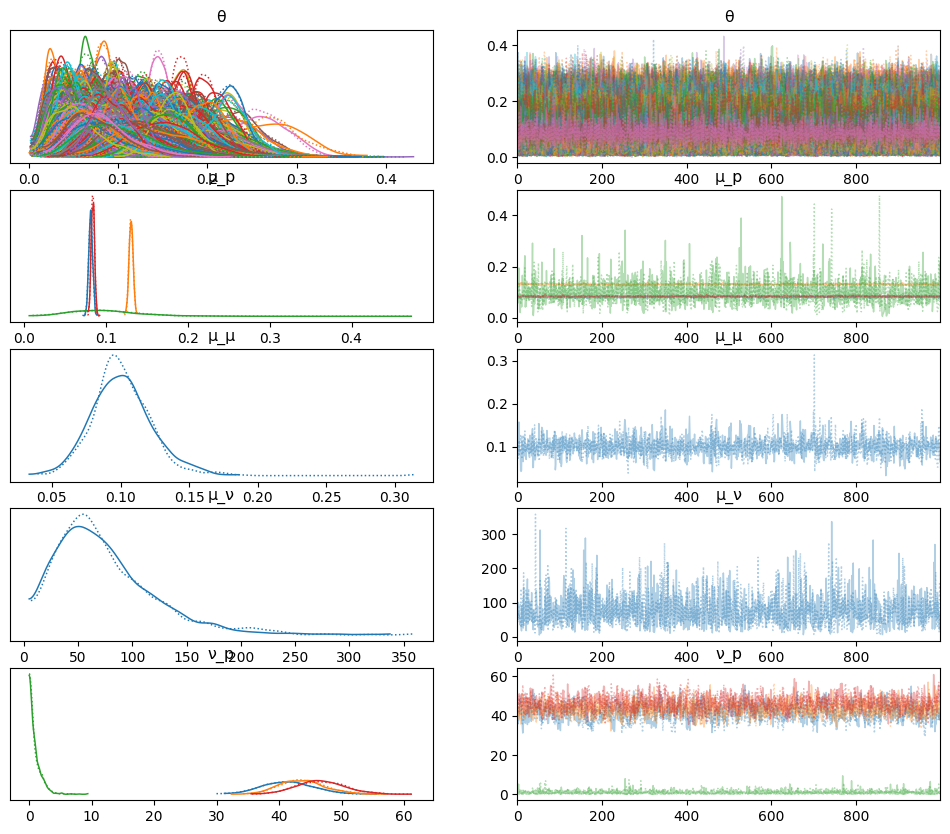

In [24]:
az.plot_trace(idata_sccr_h_no_gk)

The model without goalkeepers is easier for pymc to handle because it has less data to process. Without the GKs, the graph looks more normal and no longer has the large peak around 200. Howeveer, by removing the GKs, we lose a key part of the dataset, which affects the overall analysis since that peak around 200 is missing. If we only want tto focus on defenders, midfielders, and forwards, excluding GKs could be useful because it reduces the emphasis on that peak. But if we’re aiming to represent soccer as a whole, leaving out GKs wouldn’t give an accurate picture. So, it depends on what we want from the data and our analysis focus.